In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/data challenge/datachallenge


Mounted at /content/gdrive
/content/gdrive/MyDrive/data challenge/datachallenge


In [ ]:
#%cd /content/gdrive/MyDrive/data challenge/datachallenge

In [2]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
# Display of the five rythms + the initial EEG
import numpy as np
import matplotlib.pyplot as plt

# create an image by projecting the information in the XY plan follow by a 2D interpolation between each points.
import math as m

from tqdm import tqdm
from scipy.interpolate import griddata, interp1d
from sklearn.preprocessing import scale

from mpl_toolkits import mplot3d


# Data Loading : 


The dimension of the training set is  (2136, 64, 3)
The dimension of the training labels is  (2136,)
The dimension of the training set with time is  (2136, 1344)
The dimension of the testing set is  (533, 64, 3)
The dimension of the testing set is  (533, 1344)


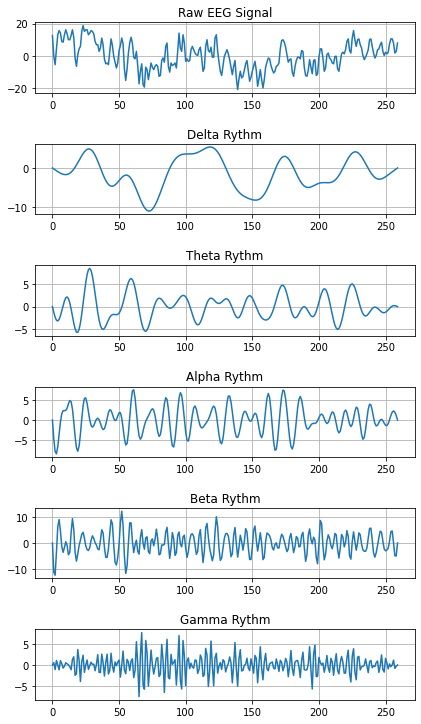

In [6]:
# Start writing code here...

sig = np.load('sig.npy')

info = ['Raw EEG Signal', 'Delta Rythm', 'Theta Rythm', 'Alpha Rythm',
        'Beta Rythm', 'Gamma Rythm']

fig, ax = plt.subplots(6, figsize=(6,10))
fig.tight_layout(h_pad=3)
for i in range(6):
  ax[i].plot(sig[i])
  ax[i].set_title(info[i])
  ax[i].grid()

# upload the datsets
X_train = np.load('X_train.npy')
y_train = np.load('y_train.npy')
print('The dimension of the training set is ', X_train.shape)
print('The dimension of the training labels is ', y_train.shape)

X_train_time = np.load('X_train_7time.npy')
print('The dimension of the training set with time is ', X_train_time.shape)

X_test = np.load('X_test.npy')
print('The dimension of the testing set is ', X_test.shape)

X_test_time = np.load('X_test_7time.npy')
print('The dimension of the testing set is ', X_test_time.shape)

X_train_brut = np.load('X_train.npy')
y_train_brut = np.load('y_train.npy')

Fonctions utiles utilisées pendant le challenge : 

In [7]:
def band_image(frequency_band, electrodes_location, img_size=32):
    locs_2d = elec_proj( electrodes_location )
    frequency_band = frequency_band / np.min( frequency_band )
    frequency_band = frequency_band.reshape( (frequency_band.shape[0], -1) )

    images = image_generation( frequency_band, locs_2d, img_size )
    return images

def elec_proj(loc_3d): 
    locs_2d = []
    for l in loc_3d: 
        locs_2d.append( azim_proj( l ) ) 
    return np.asarray( locs_2d ) 

def azim_proj(pos):
    [r, elev, az] = cart2sph( pos[0], pos[1], pos[2] )

    return pol2cart( az, m.pi / 2 - elev )

def pol2cart(theta, rho):
    return rho * m.cos( theta ), rho * m.sin( theta )

def cart2sph(x, y, z): ## converti coordonnées cartésienne en sphérique
    x2_y2 = x ** 2 + y ** 2
    r = m.sqrt( x2_y2 + z ** 2 )  # r
    elev = m.atan2( z, m.sqrt( x2_y2 ) )  # Elevation
    az = m.atan2( y, x )  # Azimuth
    return r, elev, az

def image_generation(feature_matrix, electrodes_loc, n_gridpoints):
    n_electrodes = electrodes_loc.shape[0]  # number of electrodes : 64 
    n_bands = feature_matrix.shape[1] // n_electrodes  # number of frequency bands considered in the feature matrix : 3
    n_samples = feature_matrix.shape[0]  # number of samples to consider in the feature matrix.

    # Checking the dimension of the feature matrix
    if feature_matrix.shape[1] % n_electrodes != 0:
        print( 'The combination feature matrix - electrodes locations is not working.' )
    assert feature_matrix.shape[1] % n_electrodes == 0
    new_feat = []

    # Reshape a novel feature matrix with a list of array with shape [n_samples x n_electrodes] for each frequency band
    for bands in range( n_bands ):
        new_feat.append( feature_matrix[:, bands * n_electrodes: (bands + 1) * n_electrodes] ) ## new_feat : 3, 2100, 64
 
    # Creation of a meshgrid data interpolation
    #   Creation of an empty grid
    grid_x, grid_y = np.mgrid[
                     np.min( electrodes_loc[:, 0] ): np.max( electrodes_loc[:, 0] ): n_gridpoints * 1j,  # along x_axis
                     np.min( electrodes_loc[:, 1] ): np.max( electrodes_loc[:, 1] ): n_gridpoints * 1j  # along y_axis
                     ]

    interpolation_img = []
    #   Interpolation
    #       Creation of the empty interpolated feature matrix
    for bands in range( n_bands ):
        interpolation_img.append( np.zeros( [n_samples, n_gridpoints, n_gridpoints] ) )
    print('interpolation_image : ', np.array(interpolation_img).shape)

    #   Interpolation between the points
    # print('Signals interpolations.')
    for sample in tqdm( range( n_samples ) ):
        for bands in range( n_bands ):
            interpolation_img[bands][sample, :, :] = griddata( electrodes_loc, new_feat[bands][sample, :],
                                                               (grid_x, grid_y), method='cubic', fill_value=np.nan )
    #   Normalization - replacing the nan values by interpolation
    for bands in range( n_bands ):
        interpolation_img[bands][~np.isnan( interpolation_img[bands] )] = scale(
            interpolation_img[bands][~np.isnan( interpolation_img[bands] )] )
        interpolation_img[bands] = np.nan_to_num( interpolation_img[bands] )

    print('swap : ', np.swapaxes( np.asarray( interpolation_img ), 0, 1 ).shape)
    return np.swapaxes( np.asarray( interpolation_img ), 0, 1 )  # swap axes to have [samples, colors, W, H] ## (2136, 3, 32, 32)

Position des électrodes en 3D : 

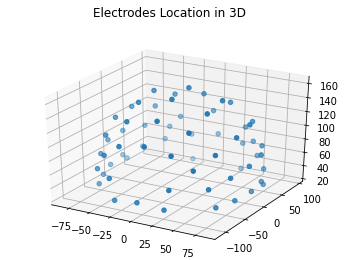

In [8]:
# Display of 3D position of each electrodes
channel_information = np.load('ChanInfo.npy', allow_pickle=True).all() ## dict + shape : (64, 3) --> coordonnées des 64 EEG channels

fig = plt.figure()
ax = plt.axes(projection="3d")

ax.scatter3D(channel_information['position'][:, 0], channel_information['position'][:, 1], channel_information['position'][:, 2])
plt.suptitle("Electrodes Location in 3D")
plt.show()

Création des data sets ( Azimuthal Equidistant projections réalisés pour créer les images) : 

- Premier data set : 

In [9]:
## Image Creation
print('Image Creation')
Electrodes_position = channel_information['position'] ## array (64,3)
X_image_train = band_image(X_train, Electrodes_position, 32)

X_image_test = band_image(X_test, Electrodes_position, 32)


#command specific to keras (need to have n_channels x Height x Width as shape)
#implementation made with pytorch wich is a clearly better lib ;)
X_image_train = X_image_train.swapaxes(1,-1)
X_image_test = X_image_test.swapaxes(1,-1)

  1%|          | 15/2136 [00:00<00:14, 146.41it/s]

Image Creation
interpolation_image :  (3, 2136, 32, 32)


  4%|▎         | 19/533 [00:00<00:02, 187.19it/s]

swap :  (2136, 3, 32, 32)
interpolation_image :  (3, 533, 32, 32)


100%|██████████| 533/533 [00:03<00:00, 177.34it/s]

swap :  (533, 3, 32, 32)


- Second Dataset : 

In [10]:
X_image_train_time = band_image(X_train_time, Electrodes_position)
X_image_test_time = band_image(X_test_time, Electrodes_position)
X_image_train_time = X_image_train_time.reshape(-1,7,3,32,32).swapaxes(2,-1)
X_image_test_time =  X_image_test_time.reshape(-1,7,3,32,32).swapaxes(2,-1)

  0%|          | 3/2136 [00:00<01:19, 26.73it/s]

interpolation_image :  (21, 2136, 32, 32)


  0%|          | 0/533 [00:00<?, ?it/s]

swap :  (2136, 21, 32, 32)
interpolation_image :  (21, 533, 32, 32)


100%|██████████| 533/533 [00:20<00:00, 25.65it/s]


swap :  (533, 21, 32, 32)


##Data visualisation :  

Visualisation des coefficients alpha, Beta et Gamma correspondant à une acquisition donnée : 

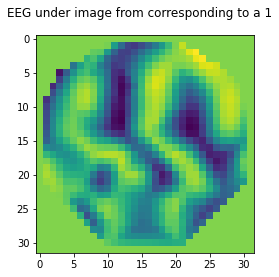

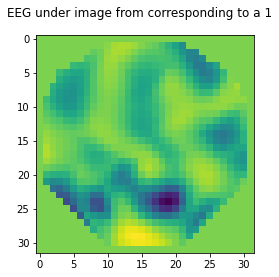

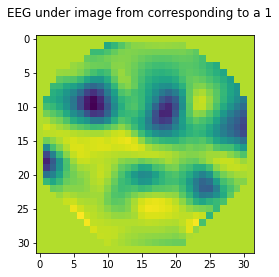

In [11]:
i = 7
#plt.figure(figsize=(10, 15))
plt.imshow(X_image_train[i, :, :, 0])
plt.suptitle('EEG under image from corresponding to a '+str(y_train[i]))
plt.show()

plt.imshow(X_image_train[i, :, :, 1])
plt.suptitle('EEG under image from corresponding to a '+str(y_train[i]))
plt.show()

plt.imshow(X_image_train[i, :, :, 2])
plt.suptitle('EEG under image from corresponding to a '+str(y_train[i]))
plt.show()

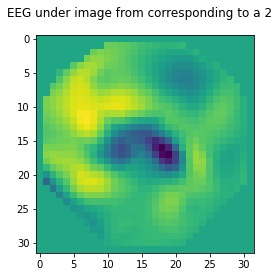

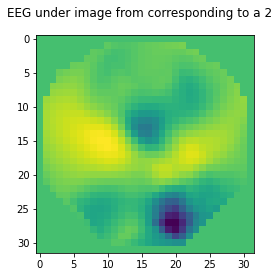

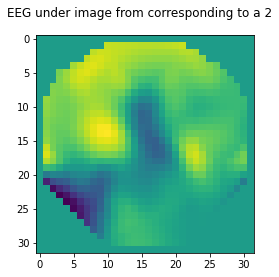

In [ ]:
plt.imshow(X_image_train_time[0, 0, : , :, 0])
plt.suptitle('EEG under image from corresponding to a '+str(y_train[0]))
plt.show()

plt.imshow(X_image_train_time[0, 0,:, :, 1])
plt.suptitle('EEG under image from corresponding to a '+str(y_train[0]))
plt.show()

plt.imshow(X_image_train_time[0, 0,:, :, 2])
plt.suptitle('EEG under image from corresponding to a '+str(y_train[0]))
plt.show()

# Modèles retenus : 

On présente ici les modèles utilisés pour gagner la compétition : 

### Model 1 : CNN entrainé sur la première base de donnée. 

Ce modèle a été entrainé sur la première base de donnée, et ne prend donc pas en compte la dimension temporelle des données. Il prend uniquement en compte les dimensions spatiales (via les positions des pixels sur chaque image d'entrainement) et fréquentielles (via chaque image associée au coefficients gamma, beta et alpha). 

On a entrainé un CNN car c'est un modèle particulièrement bien adapté à l'apprentissage sur des base de données d'images. 

In [19]:
import tensorflow as tf
from tensorflow.keras import layers, models, Model, Input

from keras.layers import concatenate, LSTM, TimeDistributed
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split


from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score



In [20]:
def model_CNN( kernel_size1 = 5, kernel_size2 = 5, Dropout = 0.3, lr=0.0005) :
  model = models.Sequential()
  model.add(layers.Conv2D(32, (kernel_size1, kernel_size1), activation='elu', input_shape=(32, 32, 3), padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(Dropout))

  model.add(layers.Conv2D(64, (kernel_size2, kernel_size2), activation='elu', input_shape=(32, 32, 3), padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(Dropout))

  model.add(layers.Conv2D(64, (3, 3), activation='elu', input_shape=(32, 32, 3),  padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(Dropout))

  model.add(layers.Flatten())
  model.add(layers.Dense(64, activation='elu'))
  model.add(layers.Dense(4))

  adam = tf.keras.optimizers.Adam(
    learning_rate=lr,
    beta_1=0.9,
    beta_2=0.999,
    name="Adam",
  )

  model.compile(optimizer= adam,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
  
  return model

In [21]:
model = model_CNN()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        2432      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        51264     
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 64)        0

Pour entrainer ce modèle et effectuer du tunning de paramètres, on a utilisé les deux fonctions suivantes : 

- La fonction train_modelCNN : 

Prend en entrée les paramètres avec lesquels on souhaite entrainer notre modèle ainsi que le nombre de modèles à entrainer (on a utilisé number_model = 6). Chacun des 6 modèles est testé sur un ensemble de validation différent. On peut ainsi avoir une meilleur idée de l'effet de la modification d'un paramètre sur l'efficacité de notre modèle. En effet, évaluer les performances d'un modèle pour un jeu de paramètres donné à partir d'un unique entrainement est peu fiable car notre modèle a une variance élevée d'un entrainement à un autre.

On sauvegarde les 6 modèles entrainés pour un jeu de paramètre afin de pouvoir les interpréter avec la fonction get_info_on_modelCNN.

In [23]:
def train_modelCNN(kernel_size1 = 3, kernel_size2 = 3, Dropout = 0.2, lr=0.001, patience=2, rate=0.6, numbers_model = 6 ): 

  num_models_CNN = numbers_model
  model_list = []
  reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=rate,
                              patience=patience, min_lr=0.00001, )

  for i in range(num_models_CNN):
    X_tr, X_val, y_tr, y_val=train_test_split(X_image_train,y_train, test_size=0.2, random_state = 100+i)

    model = model_CNN(kernel_size1, kernel_size2, Dropout, lr)    
    history = model.fit(X_tr, y_tr-1, epochs= 15, callbacks= [reduce_lr], 
                    validation_data=(X_val, y_val-1), batch_size=20) 
    
    model_list.append([model])
    print("Model " + str(i+1) + " has completed the Training")

    model.save("CNN_"+str(i+1)+".h5")
    print("Saved model to disk")


La fonction get_info_on_modelCNN permet de récupérer les informations sur les modèles entrainés. 
Pour un jeu de paramètres donné testé, on peut récupérer, à partir des 6 modèles entrainés : 

- Le taux de prédiction moyen obtenue par les 6 modèles sur leur data set de validation respectif. 
- Le nombre de fois qu'un des 6 modèle à dépasser un certain seuil de prédiction (qu'on a fixé à 0.93). 
- Le meilleur score de prédiction obtenu par un des 6 modèles + le modèle correspondant. 

In [26]:
def get_info_on_modelCNN(viz =  False , numbers_model = 6): 
  
  num_models_CNN = numbers_model
  mean_score = 0
  best_model = tf.keras.models.load_model("CNN_1.h5")
  best_score = 0
  num_baseline = 0
  
  for i in range(num_models_CNN) : 
    X_tr, X_val, y_tr, y_val=train_test_split(X_image_train,y_train, test_size=0.2, random_state = 100+i)
    model = tf.keras.models.load_model("CNN_"+str(i+1)+".h5")
    y_pred_model1 = np.argmax(model.predict(X_val), axis = 1)

    if viz == True : 
      print('model', i+1)
      print(accuracy_score(y_val-1, y_pred_model1))
      print(confusion_matrix(y_val-1,  y_pred_model1))

    if accuracy_score(y_val-1, y_pred_model1) >  best_score : 
      best_score =  accuracy_score(y_val-1, y_pred_model1) 
      best_model = model

    if accuracy_score(y_val-1, y_pred_model1) > 0.93 : 
      num_baseline+=1
    
    mean_score += accuracy_score(y_val-1, y_pred_model1)
  
  mean_score = mean_score/num_models_CNN 
  print('average ', mean_score)
  return mean_score, num_baseline, best_score, best_model

### Model Tunning : 

Les paramètres que l'on a optimisé pour ce premier modèle sont les suivants : 

In [27]:
kernel_size1 = [2, 3, 4, 5]
kernel_size2 = [2, 3, 4, 5]
dropout = [0.4]
learning_rate = [0.005, 0.001, 0.0005]
patiences=[1,2,3,4]
rates=[0.7,.8,.9]

Script utilisé pour le tunning des paramètres : 


In [ ]:
L_average = []
L_best_score = []
L_number_baseline = []
for rate in rates :
  train_model(kernel_size1 = 3, kernel_size2 = 3, Dropout = .4, lr=lr, patience=2, rate=rate)
  infos=get_info_on_model()
  L_average.append(infos[0])
  L_number_baseline.append(infos[1])
  L_best_score.append(infos[2])
  print(3*'\n')

Epoch 1/15
86/86 [==============================] - 2s 13ms/step - loss: 1.6483 - accuracy: 0.5926 - val_loss: 1.9510 - val_accuracy: 0.4463
Epoch 2/15
86/86 [==============================] - 1s 10ms/step - loss: 0.3317 - accuracy: 0.8765 - val_loss: 1.6310 - val_accuracy: 0.6379
Epoch 3/15
86/86 [==============================] - 1s 10ms/step - loss: 0.2935 - accuracy: 0.8987 - val_loss: 0.6626 - val_accuracy: 0.8388
Epoch 4/15
86/86 [==============================] - 1s 9ms/step - loss: 0.2528 - accuracy: 0.9021 - val_loss: 0.3130 - val_accuracy: 0.9065
Epoch 5/15
86/86 [==============================] - 1s 10ms/step - loss: 0.1618 - accuracy: 0.9305 - val_loss: 0.2046 - val_accuracy: 0.8972
Epoch 6/15
86/86 [==============================] - 1s 10ms/step - loss: 0.1542 - accuracy: 0.9303 - val_loss: 0.4175 - val_accuracy: 0.9206
Epoch 7/15
86/86 [==============================] - 1s 10ms/step - loss: 0.1389 - accuracy: 0.9345 - val_loss: 0.1887 - val_accuracy: 0.9065
Epoch 8/15
86/

Finalement,  le meilleur modèle que l'on a retenu correspondait aux paramètres suivants : 

- kernel_size1 = 5
- kernel_size2 = 5
- dropout = 0.3
- learning_rate= 0.0005

Paramètres utilisés pour ReduceLROnPlateau : 
- patience=1   
- rate= 0.3

## Model 2 : CNN-LSTM sur la deuxième base de donnée 

Pour définir le modèle CNN-LSTM, on a utilisé les deux fonctions suivantes. La première permet de définir la partie 'CNN' du modèle, qui est appliquée sur chacune des 7 frames des données d'entrées. 

La deuxième fonction model2_RNN permet de définir la partie 'LSTM' du modèle. Elle fait appel à la première fonction model2_CNN afin de définir le modèle complet : 

In [29]:
def model2_CNN(kernel_size = 3, kernel_size2 = 3, Dropout = 0.2) :
  
  model = models.Sequential()
  model.add(Input(shape = (32, 32, 3), name = 'input'))
  model.add(layers.Conv2D(32, (kernel_size, kernel_size), activation='elu', padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.BatchNormalization())

  model.add(layers.Conv2D(32, (kernel_size2, kernel_size2), activation='elu', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(Dropout))

  model.add(layers.Conv2D(64, (3, 3), activation='elu', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(Dropout))

  model.add(layers.Conv2D(128, (3, 3), activation='elu',  padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(Dropout))

  return model

model = model2_CNN()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 16, 16, 32)        128       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
batch_normalization_4 (Batch (None, 16, 16, 32)        128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 8, 8, 32)         

In [30]:
def model2_RNN(number_units = 128, Dropout = 0.2, kernel_size = 3, kernel_size2 = 3, learning_rate = 0.01) : 

  #inputs = Input(shape=(7, 32, 32, 3))
  model = models.Sequential()
  model.add(Input(shape=(7, 32, 32, 3)))
  model.add(TimeDistributed(model2_CNN(Dropout = Dropout, kernel_size=kernel_size, kernel_size2 = kernel_size2)))
  model.add(tf.keras.layers.Reshape((7, 4*4*128)))
  model.add(LSTM(number_units))
  model.add(layers.Dense(512, activation='elu'))
  model.add(layers.Dense(4, activation = 'softmax'))

  adam = tf.keras.optimizers.Adam(
    learning_rate=learning_rate,
    beta_1=0.9,
    beta_2=0.999,
    name="Adam",
  )

  model.compile(optimizer= adam,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
  
  return model

model2 = model2_RNN()
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 7, 4, 4, 128)      103520    
_________________________________________________________________
reshape (Reshape)            (None, 7, 2048)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               1114624   
_________________________________________________________________
dense_2 (Dense)              (None, 512)               66048     
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 2052      
Total params: 1,286,244
Trainable params: 1,285,732
Non-trainable params: 512
_________________________________________________________________


### Model 2 : tunning

Pour le tunning et l'entrainement, on a utilisé les deux fonctions train_model_RNN et get_info_on_modelRNN  :

In [31]:
def train_model_RNN(number_units = 128, kernel_size = 3, kernel_size2 = 3, Dropout = 0.1, lr=0.01, patience=2, rate=0.6, num_models = 3): 

  num_models_RNN = num_models
  model_list = []
  reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=rate,
                              patience=patience, min_lr=0.00001)

  for i in range(num_models_RNN):
    X_tr, X_val, y_tr, y_val=train_test_split(X_image_train_time, y_train, test_size=0.2, random_state = 100+i)

    model = model2_RNN(number_units = number_units, kernel_size =kernel_size, Dropout= Dropout, learning_rate=lr )    
    history = model.fit(X_tr, y_tr-1, epochs= 20, callbacks= [reduce_lr], 
                    validation_data=(X_val, y_val-1), batch_size=20) 
    
    model_list.append([model])
    print("Model " + str(i+1) + " has completed the Training")

    # serialize model to JSON
    model.save("RNN_"+str(i+1)+".h5")
    print("Saved model to disk")

In [32]:
def get_info_on_modelRNN(viz =  False, num_models = 3 ): 
  
  num_models_RNN = num_models
  mean_score = 0
  best_model = tf.keras.models.load_model("RNN_1.h5")
  best_score = 0
  num_baseline = 0
  
  for i in range(num_models_RNN) : 
    X_tr, X_val, y_tr, y_val=train_test_split(X_image_train_time,y_train, test_size=0.2, random_state = 100+i)
    model = tf.keras.models.load_model("RNN_"+str(i+1)+".h5")
    y_pred = np.argmax(model.predict(X_val), axis = 1)

    if viz == True : 
      print('model', i+1)
      print(accuracy_score(y_val-1, y_pred))
      print(confusion_matrix(y_val-1,  y_pred))

    if accuracy_score(y_val-1, y_pred) >  best_score : 
      best_score =  accuracy_score(y_val-1, y_pred) 
      best_model = model

    if accuracy_score(y_val-1, y_pred) > 0.93 : 
      num_baseline+=1
    
    mean_score += accuracy_score(y_val-1, y_pred)
  
  mean_score = mean_score/num_models_RNN 
  print('average ', mean_score)
  return mean_score, num_baseline, best_score, best_model

Les paramètres que l'on a optimisé sont les suivants : 

In [33]:
kernel_size = [3, 4, 5, 6]
kernel_size2 = [3, 4, 5]
number_units = [40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260]
Dropout = [0.1, 0.2, 0.3, 0.4]
Dropout = [0.05, 0.08, 0.1, 0.12, 0.14]
learning_rate = [0.05, 0.01, 0.005, 0.001, 0.0005]


### Optimisation of kernel_size : 

Script utilisé pour l'optimisation : 

In [ ]:
L_average = []
L_best_score = []
L_number_baseline = []

for kernel in kernel_size :
  train_model_RNN(number_units = 128, kernel_size = kernel, Dropout = 0.1, lr=0.01, patience=3, rate=0.6)
  infos=get_info_on_model()
  L_average.append(infos[0])
  L_number_baseline.append(infos[1])
  L_best_score.append(infos[2])
  print(3*'\n')

Epoch 1/40
86/86 [==============================] - 3s 17ms/step - loss: 1.5960 - accuracy: 0.4618 - val_loss: 1.0999 - val_accuracy: 0.5654
Epoch 2/40
86/86 [==============================] - 1s 10ms/step - loss: 0.9794 - accuracy: 0.5957 - val_loss: 0.9608 - val_accuracy: 0.6215
Epoch 3/40
86/86 [==============================] - 1s 10ms/step - loss: 0.8898 - accuracy: 0.6467 - val_loss: 0.9621 - val_accuracy: 0.6355
Epoch 4/40
86/86 [==============================] - 1s 10ms/step - loss: 0.8477 - accuracy: 0.6790 - val_loss: 1.0011 - val_accuracy: 0.6963
Epoch 5/40
86/86 [==============================] - 1s 12ms/step - loss: 0.7793 - accuracy: 0.6965 - val_loss: 0.6853 - val_accuracy: 0.7430
Epoch 6/40
86/86 [==============================] - 1s 10ms/step - loss: 0.7974 - accuracy: 0.7131 - val_loss: 0.9976 - val_accuracy: 0.6963
Epoch 7/40
86/86 [==============================] - 1s 10ms/step - loss: 0.8070 - accuracy: 0.7376 - val_loss: 0.7372 - val_accuracy: 0.6659
Epoch 8/40
86

In [ ]:
plt.figure(figsize = (10,15))
plt.plot(kernel_size, L_average)
plt.title('kernel_size1 : average accuracy')
plt.xlabel('kernel_size')
plt.ylabel('accuracy')

In [ ]:
plt.plot(kernel_size, L_number_baseline)
plt.title('kernel_size1 : number_baseline')
plt.xlabel('kernel_size')
plt.ylabel('accuracy')

Text(0, 0.5, 'accuracy')

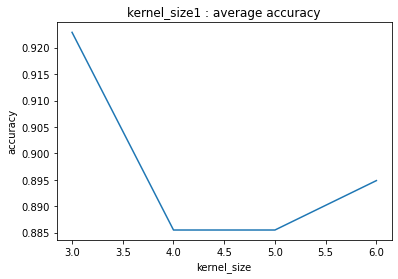

In [ ]:
plt.plot(kernel_size, L_best_score)
plt.title('kernel_size1 : best_score')
plt.xlabel('kernel_size')
plt.ylabel('accuracy')

Valeur de kernel_size gardée : 3

### Optimisation de Kernel_size2 : 

In [ ]:
kernel1_size_opt = 3
L_average = []
L_best_score = []
L_number_baseline = []

for kernel in kernel_size2 :
  train_model_RNN(number_units = 128, kernel_size = kernel1_size_opt, kernel_size2 = kernel ,Dropout = 0.1, lr=0.01, patience=3, rate=0.6)
  infos=get_info_on_model()
  L_average.append(infos[0])
  L_number_baseline.append(infos[1])
  L_best_score.append(infos[2])
  print(3*'\n')

Epoch 1/40
86/86 [==============================] - 4s 23ms/step - loss: 1.6229 - accuracy: 0.4285 - val_loss: 1.1738 - val_accuracy: 0.4533
Epoch 2/40
86/86 [==============================] - 1s 10ms/step - loss: 1.1723 - accuracy: 0.5198 - val_loss: 1.1166 - val_accuracy: 0.5467
Epoch 3/40
86/86 [==============================] - 1s 10ms/step - loss: 0.9934 - accuracy: 0.6024 - val_loss: 1.0596 - val_accuracy: 0.5607
Epoch 4/40
86/86 [==============================] - 1s 10ms/step - loss: 0.9081 - accuracy: 0.6466 - val_loss: 0.8935 - val_accuracy: 0.6425
Epoch 5/40
86/86 [==============================] - 1s 10ms/step - loss: 0.8536 - accuracy: 0.6679 - val_loss: 1.0074 - val_accuracy: 0.6285
Epoch 6/40
86/86 [==============================] - 1s 10ms/step - loss: 0.9046 - accuracy: 0.6809 - val_loss: 1.1904 - val_accuracy: 0.5654
Epoch 7/40
86/86 [==============================] - 1s 10ms/step - loss: 1.2045 - accuracy: 0.5794 - val_loss: 0.9520 - val_accuracy: 0.6612
Epoch 8/40
86

[0.8707165109034268, 0.8792834890965732, 0.8909657320872274]

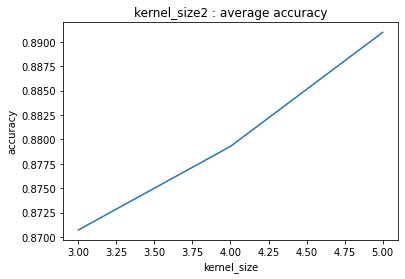

In [ ]:
plt.plot(kernel_size2, L_average)
plt.title('kernel_size2 : average accuracy')
plt.xlabel('kernel_size')
plt.ylabel('accuracy')
L_average

Text(0, 0.5, 'accuracy')

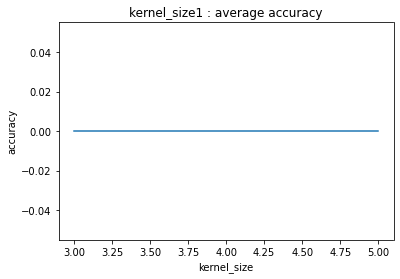

In [ ]:
plt.plot(kernel_size2, L_number_baseline)
plt.title('kernel_size1 : average accuracy')
plt.xlabel('kernel_size')
plt.ylabel('accuracy')

[0.8948598130841121, 0.897196261682243, 0.8995327102803738]

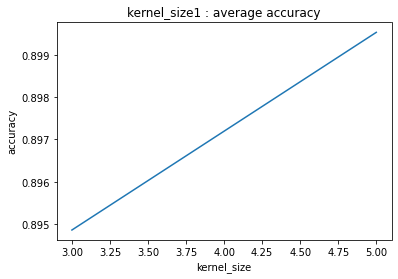

In [ ]:
plt.plot(kernel_size2, L_best_score)
plt.title('kernel_size1 : average accuracy')
plt.xlabel('kernel_size')
plt.ylabel('accuracy')
L_best_score

Valeurde Kernel_size2 retenue : 5

### Optimisation du Learning_rate : 

In [ ]:
kernel1_size_opt = 3
kernel2_size_opt = 5
L_average = []
L_best_score = []
L_number_baseline = []

for lr in learning_rate :
  train_model_RNN(number_units = 128, kernel_size = kernel1_size_opt, kernel_size2 = kernel2_size_opt, Dropout = 0.1, lr= lr, patience=3, rate=0.6)
  infos=get_info_on_model()
  L_average.append(infos[0])
  L_number_baseline.append(infos[1])
  L_best_score.append(infos[2])
  print(3*'\n')

Epoch 1/40
86/86 [==============================] - 3s 17ms/step - loss: 4.8613 - accuracy: 0.3346 - val_loss: 2.6778 - val_accuracy: 0.2407
Epoch 2/40
86/86 [==============================] - 1s 10ms/step - loss: 2.4692 - accuracy: 0.3589 - val_loss: 4.3696 - val_accuracy: 0.3645
Epoch 3/40
86/86 [==============================] - 1s 10ms/step - loss: 3.5796 - accuracy: 0.3910 - val_loss: 5.1420 - val_accuracy: 0.2266
Epoch 4/40
86/86 [==============================] - 1s 10ms/step - loss: 5.4176 - accuracy: 0.3223 - val_loss: 5.2922 - val_accuracy: 0.2266
Epoch 5/40
86/86 [==============================] - 1s 10ms/step - loss: 2.6381 - accuracy: 0.3985 - val_loss: 2.5000 - val_accuracy: 0.4159
Epoch 6/40
86/86 [==============================] - 1s 10ms/step - loss: 2.1190 - accuracy: 0.3875 - val_loss: 2.6421 - val_accuracy: 0.3014
Epoch 7/40
86/86 [==============================] - 1s 16ms/step - loss: 1.7108 - accuracy: 0.4198 - val_loss: 1.4884 - val_accuracy: 0.3107
Epoch 8/40
86

average [0.5560747663551402, 0.897196261682243, 0.9065420560747665, 0.9228971962616823, 0.9213395638629284]
number_baseline [0, 0, 0, 3, 3]
best_score [0.6355140186915887, 0.9042056074766355, 0.9088785046728972, 0.9322429906542056, 0.9252336448598131]


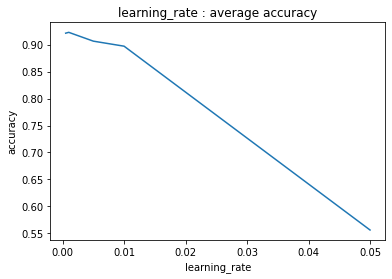

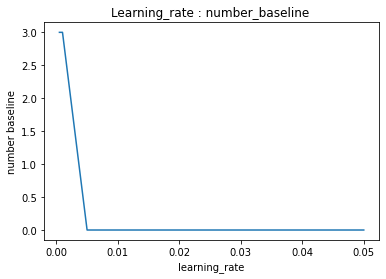

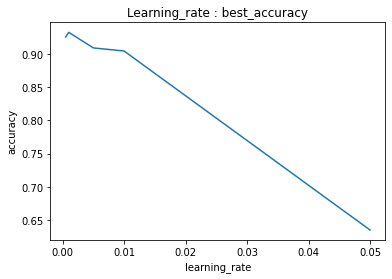

In [ ]:
plt.figure()
plt.plot(learning_rate, L_average)
plt.title('learning_rate : average accuracy')
plt.xlabel('learning_rate')
plt.ylabel('accuracy')
print('average',L_average)

plt.figure()
plt.plot(learning_rate, L_number_baseline)
plt.title('Learning_rate : number_baseline ')
plt.xlabel('learning_rate')
plt.ylabel('number baseline')
print('number_baseline', L_number_baseline)

plt.figure()
plt.plot(learning_rate, L_best_score)
plt.title('Learning_rate : best_accuracy')
plt.xlabel('learning_rate')
plt.ylabel('accuracy')

print('best_score', L_best_score)


In [ ]:
learning_rate = [0.001, 0.0009, 0.0008,0.0007, 0.0006, 0.0005, 0.0004, 0.0003]

kernel1_size_opt = 3
kernel2_size_opt = 5
L_average = []
L_best_score = []
L_number_baseline = []

for lr in learning_rate :
  train_model_RNN(number_units = 128, kernel_size = kernel1_size_opt, kernel_size2 = kernel2_size_opt, Dropout = 0.1, lr= lr, patience=3, rate=0.6)
  infos=get_info_on_model()
  L_average.append(infos[0])
  L_number_baseline.append(infos[1])
  L_best_score.append(infos[2])
  print(3*'\n')


Epoch 1/20
86/86 [==============================] - 4s 17ms/step - loss: 0.6831 - accuracy: 0.7223 - val_loss: 0.8558 - val_accuracy: 0.7243
Epoch 2/20
86/86 [==============================] - 1s 10ms/step - loss: 0.2560 - accuracy: 0.8964 - val_loss: 0.2461 - val_accuracy: 0.8925
Epoch 3/20
86/86 [==============================] - 1s 10ms/step - loss: 0.1639 - accuracy: 0.9226 - val_loss: 0.2724 - val_accuracy: 0.8995
Epoch 4/20
86/86 [==============================] - 1s 10ms/step - loss: 0.1479 - accuracy: 0.9314 - val_loss: 0.2249 - val_accuracy: 0.9065
Epoch 5/20
86/86 [==============================] - 1s 10ms/step - loss: 0.1315 - accuracy: 0.9369 - val_loss: 0.2123 - val_accuracy: 0.8902
Epoch 6/20
86/86 [==============================] - 1s 10ms/step - loss: 0.1336 - accuracy: 0.9268 - val_loss: 0.1924 - val_accuracy: 0.9042
Epoch 7/20
86/86 [==============================] - 1s 10ms/step - loss: 0.1500 - accuracy: 0.9312 - val_loss: 0.2457 - val_accuracy: 0.9065
Epoch 8/20
86

average [0.9213395638629284, 0.9213395638629284, 0.9244548286604362, 0.9236760124610592, 0.9213395638629284, 0.927570093457944, 0.9275700934579438, 0.9190031152647976]
number_baseline [1, 2, 2, 2, 1, 3, 2, 2]
best_score [0.9345794392523364, 0.9252336448598131, 0.9322429906542056, 0.9322429906542056, 0.9322429906542056, 0.9345794392523364, 0.9322429906542056, 0.9228971962616822]


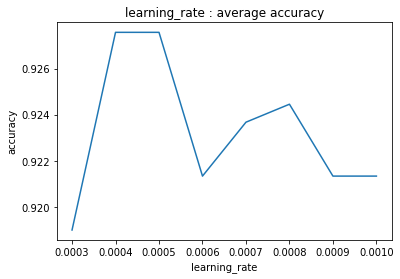

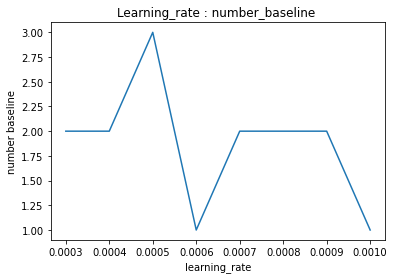

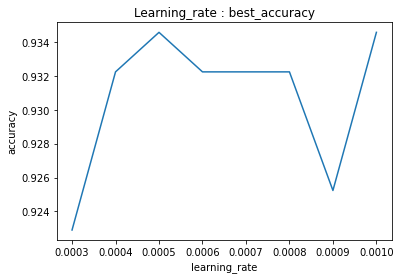

In [ ]:
plt.figure()
plt.plot(learning_rate, L_average)
plt.title('learning_rate : average accuracy')
plt.xlabel('learning_rate')
plt.ylabel('accuracy')
print('average',L_average)

plt.figure()
plt.plot(learning_rate, L_number_baseline)
plt.title('Learning_rate : number_baseline ')
plt.xlabel('learning_rate')
plt.ylabel('number baseline')
print('number_baseline', L_number_baseline)

plt.figure()
plt.plot(learning_rate, L_best_score)
plt.title('Learning_rate : best_accuracy')
plt.xlabel('learning_rate')
plt.ylabel('accuracy')

print('best_score', L_best_score)

Learning_rate retenu : 0.0005

### Optimisation de Number_Units 

In [ ]:
number_units = [40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260]

kernel1_size_opt = 3
kernel2_size_opt = 5
lr_opt = 0.0005
L_average = []
L_best_score = []
L_number_baseline = []

for units in number_units :
  train_model_RNN(number_units = units, kernel_size = kernel1_size_opt, kernel_size2 = kernel2_size_opt, Dropout = 0.1, lr= lr_opt, patience=3, rate=0.6)
  infos=get_info_on_model()
  L_average.append(infos[0])
  L_number_baseline.append(infos[1])
  L_best_score.append(infos[2])
  print(3*'\n')




Epoch 1/20
86/86 [==============================] - 3s 16ms/step - loss: 0.8410 - accuracy: 0.6772 - val_loss: 0.5216 - val_accuracy: 0.7593
Epoch 2/20
86/86 [==============================] - 1s 10ms/step - loss: 0.1932 - accuracy: 0.9205 - val_loss: 0.2528 - val_accuracy: 0.8855
Epoch 3/20
86/86 [==============================] - 1s 10ms/step - loss: 0.1496 - accuracy: 0.9338 - val_loss: 0.1930 - val_accuracy: 0.8995
Epoch 4/20
86/86 [==============================] - 1s 10ms/step - loss: 0.1236 - accuracy: 0.9293 - val_loss: 0.1667 - val_accuracy: 0.9065
Epoch 5/20
86/86 [==============================] - 1s 10ms/step - loss: 0.1436 - accuracy: 0.9279 - val_loss: 0.2069 - val_accuracy: 0.9089
Epoch 6/20
86/86 [==============================] - 1s 10ms/step - loss: 0.1144 - accuracy: 0.9362 - val_loss: 0.1687 - val_accuracy: 0.9112
Epoch 7/20
86/86 [==============================] - 1s 10ms/step - loss: 0.1033 - accuracy: 0.9379 - val_loss: 0.1632 - val_accuracy: 0.9112
Epoch 8/20
86

average [0.9190031152647974, 0.9252336448598131, 0.9244548286604362, 0.9228971962616822, 0.9267912772585669, 0.9244548286604362, 0.9205607476635514, 0.9236760124610592, 0.9166666666666666, 0.9228971962616822, 0.92601246105919, 0.9221183800623053]
number_baseline [0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1]
best_score [0.9252336448598131, 0.9322429906542056, 0.9299065420560748, 0.927570093457944, 0.9299065420560748, 0.9299065420560748, 0.9252336448598131, 0.9369158878504673, 0.9322429906542056, 0.927570093457944, 0.9345794392523364, 0.9345794392523364]


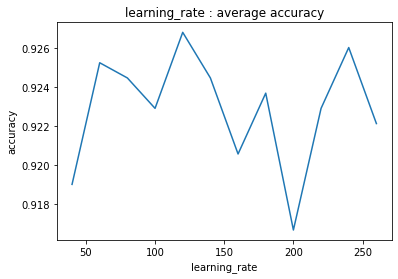

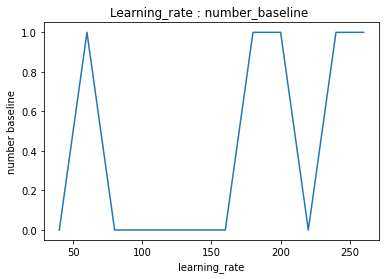

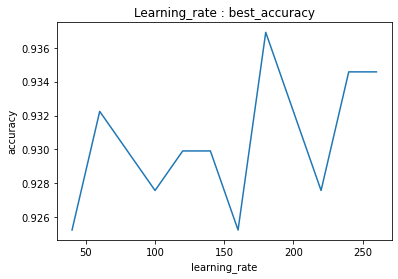

In [ ]:
plt.figure()
plt.plot(number_units, L_average)
plt.title('learning_rate : average accuracy')
plt.xlabel('learning_rate')
plt.ylabel('accuracy')
print('average',L_average)

plt.figure()
plt.plot(number_units, L_number_baseline)
plt.title('Learning_rate : number_baseline ')
plt.xlabel('learning_rate')
plt.ylabel('number baseline')
print('number_baseline', L_number_baseline)

plt.figure()
plt.plot(number_units, L_best_score)
plt.title('Learning_rate : best_accuracy')
plt.xlabel('learning_rate')
plt.ylabel('accuracy')

print('best_score', L_best_score)

- Number_of_units retenue: 120. (On a finalement gardé 128).

In [ ]:
Dropout = [0.05, 0.06, 0.08, 0.1, 0.12, 0.15]

kernel1_size_opt = 3
kernel2_size_opt = 5
lr_opt = 0.0005
number_units_opt = 120
L_average = []
L_best_score = []
L_number_baseline = []

for dropout in Dropout :
  train_model_RNN(number_units = 120, kernel_size = kernel1_size_opt, kernel_size2 = kernel2_size_opt, Dropout = dropout, lr= lr_opt, patience=3, rate=0.6)
  infos=get_info_on_model()
  L_average.append(infos[0])
  L_number_baseline.append(infos[1])
  L_best_score.append(infos[2])
  print(3*'\n')




Epoch 1/20
86/86 [==============================] - 4s 17ms/step - loss: 0.7387 - accuracy: 0.7098 - val_loss: 0.4727 - val_accuracy: 0.8341
Epoch 2/20
86/86 [==============================] - 1s 10ms/step - loss: 0.1878 - accuracy: 0.9210 - val_loss: 0.2136 - val_accuracy: 0.9065
Epoch 3/20
86/86 [==============================] - 1s 10ms/step - loss: 0.1284 - accuracy: 0.9460 - val_loss: 0.1465 - val_accuracy: 0.9322
Epoch 4/20
86/86 [==============================] - 1s 10ms/step - loss: 0.1482 - accuracy: 0.9310 - val_loss: 0.1785 - val_accuracy: 0.9136
Epoch 5/20
86/86 [==============================] - 1s 10ms/step - loss: 0.1211 - accuracy: 0.9392 - val_loss: 0.1573 - val_accuracy: 0.9112
Epoch 6/20
86/86 [==============================] - 1s 10ms/step - loss: 0.1031 - accuracy: 0.9427 - val_loss: 0.1689 - val_accuracy: 0.9159
Epoch 7/20
86/86 [==============================] - 1s 10ms/step - loss: 0.0957 - accuracy: 0.9566 - val_loss: 0.1460 - val_accuracy: 0.9159
Epoch 8/20
86

average [0.9252336448598131, 0.9244548286604362, 0.9228971962616823, 0.927570093457944, 0.9275700934579438, 0.9228971962616823]
number_baseline [1, 0, 2, 1, 2, 1]
best_score [0.9322429906542056, 0.9299065420560748, 0.9322429906542056, 0.9369158878504673, 0.9322429906542056, 0.9322429906542056]


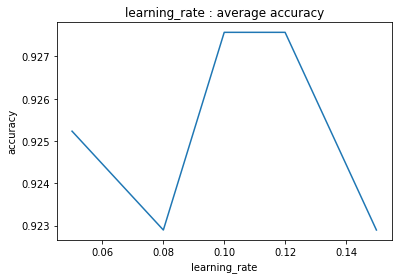

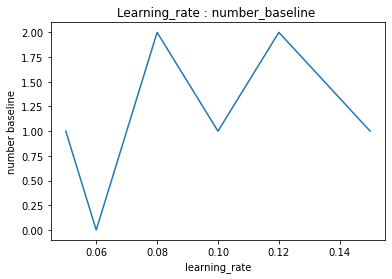

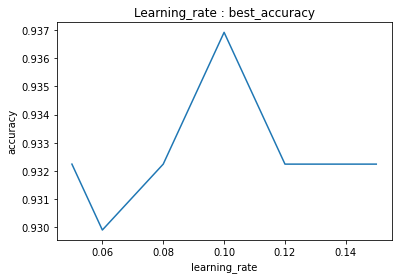

In [ ]:
plt.figure()
plt.plot(Dropout, L_average)
plt.title('learning_rate : average accuracy')
plt.xlabel('learning_rate')
plt.ylabel('accuracy')
print('average',L_average)

plt.figure()
plt.plot(Dropout, L_number_baseline)
plt.title('Learning_rate : number_baseline ')
plt.xlabel('learning_rate')
plt.ylabel('number baseline')
print('number_baseline', L_number_baseline)

plt.figure()
plt.plot(Dropout, L_best_score)
plt.title('Learning_rate : best_accuracy')
plt.xlabel('learning_rate')
plt.ylabel('accuracy')

print('best_score', L_best_score)

Dropout retenu : 0.12. 

Finalement, on a retenu les paramètres suivants : 

- Kernel_size1 = 3
- Kernel_size2 = 5
- Learning_rate = 0.0005
- Dropout = 0.12

## Entrainement des meilleurs modèles : 


Pour chaque modèle (CNN ou CNN-LSTM), on a entrainé 6 modèles sur des data set de validation distinct et on a gardé le meilleur : 

Remarque : Ceci a été une démarche intermiédiare pour tester nos modèles sur Kaggle. Ici, les meilleurs modèles ne sont pas entrianés sur toute la base de donnée. IL se trouve que c'est l'entrainement sur toute la base de donnée qui nous a permis finalement de remporter la compétition. 

Entrainement du meilleur model CNN : 

In [ ]:
train_modelCNN(kernel_size1 = 5, kernel_size2 = 5, Dropout = 0.3, lr=0.0005, patience=1, rate=0.3)
model = get_info_on_modelCNN(viz=True, numbers_model =  6)

best_modelCNN1 = model[3]

Epoch 1/15
86/86 [==============================] - 1s 9ms/step - loss: 1.1580 - accuracy: 0.6503 - val_loss: 0.3932 - val_accuracy: 0.8411
Epoch 2/15
86/86 [==============================] - 1s 6ms/step - loss: 0.2717 - accuracy: 0.8949 - val_loss: 0.2754 - val_accuracy: 0.8855
Epoch 3/15
86/86 [==============================] - 1s 6ms/step - loss: 0.2248 - accuracy: 0.9066 - val_loss: 0.2960 - val_accuracy: 0.8855
Epoch 4/15
86/86 [==============================] - 1s 6ms/step - loss: 0.2040 - accuracy: 0.8999 - val_loss: 0.1729 - val_accuracy: 0.9089
Epoch 5/15
86/86 [==============================] - 1s 6ms/step - loss: 0.1318 - accuracy: 0.9322 - val_loss: 0.1679 - val_accuracy: 0.9112
Epoch 6/15
86/86 [==============================] - 0s 6ms/step - loss: 0.1291 - accuracy: 0.9302 - val_loss: 0.1637 - val_accuracy: 0.8972
Epoch 7/15
86/86 [==============================] - 0s 6ms/step - loss: 0.1149 - accuracy: 0.9377 - val_loss: 0.1650 - val_accuracy: 0.9206
Epoch 8/15
86/86 [==

Remarque : on a entrainé un autre modèle CNN dont les paramètres choisis semblaient également très bon : 

In [ ]:
train_modelCNN(kernel_size1 = 3, kernel_size2 = 3, Dropout = 0.3, lr=0.0005, patience=1, rate=0.3)
model = get_info_on_modelCNN(viz=True, numbers_model =  6)

best_modelCNN2 = model[3]

Epoch 1/15
86/86 [==============================] - 1s 8ms/step - loss: 1.1264 - accuracy: 0.6648 - val_loss: 0.6165 - val_accuracy: 0.8084
Epoch 2/15
86/86 [==============================] - 0s 5ms/step - loss: 0.4037 - accuracy: 0.8792 - val_loss: 0.3882 - val_accuracy: 0.8645
Epoch 3/15
86/86 [==============================] - 0s 5ms/step - loss: 0.2864 - accuracy: 0.9035 - val_loss: 0.2730 - val_accuracy: 0.8972
Epoch 4/15
86/86 [==============================] - 0s 5ms/step - loss: 0.2086 - accuracy: 0.9077 - val_loss: 0.2145 - val_accuracy: 0.8855
Epoch 5/15
86/86 [==============================] - 0s 5ms/step - loss: 0.1676 - accuracy: 0.9179 - val_loss: 0.2308 - val_accuracy: 0.9065
Epoch 6/15
86/86 [==============================] - 0s 5ms/step - loss: 0.1444 - accuracy: 0.9396 - val_loss: 0.2109 - val_accuracy: 0.8995
Epoch 7/15
86/86 [==============================] - 0s 5ms/step - loss: 0.1270 - accuracy: 0.9402 - val_loss: 0.2178 - val_accuracy: 0.9136
Epoch 8/15
86/86 [==

## Entrainement du meilleur modèle RNN (CNN-LSTM) : 

In [ ]:
train_model_RNN(kernel_size = 3, kernel_size2 = 5, Dropout = 0.12, lr=0.0005, patience=3, rate=0.6, num_models=6)
model = get_info_on_modelRNN(viz=True, num_models=6)

best_modelRNN1 = model[3]

Epoch 1/20
86/86 [==============================] - 4s 17ms/step - loss: 0.7466 - accuracy: 0.6861 - val_loss: 0.4477 - val_accuracy: 0.8762
Epoch 2/20
86/86 [==============================] - 1s 10ms/step - loss: 0.1881 - accuracy: 0.9157 - val_loss: 0.2794 - val_accuracy: 0.8621
Epoch 3/20
86/86 [==============================] - 1s 10ms/step - loss: 0.1274 - accuracy: 0.9432 - val_loss: 0.1741 - val_accuracy: 0.9019
Epoch 4/20
86/86 [==============================] - 1s 10ms/step - loss: 0.1442 - accuracy: 0.9203 - val_loss: 0.1533 - val_accuracy: 0.9252
Epoch 5/20
86/86 [==============================] - 1s 10ms/step - loss: 0.1147 - accuracy: 0.9430 - val_loss: 0.1695 - val_accuracy: 0.9229
Epoch 6/20
86/86 [==============================] - 1s 10ms/step - loss: 0.0989 - accuracy: 0.9463 - val_loss: 0.1862 - val_accuracy: 0.9112
Epoch 7/20
86/86 [==============================] - 1s 10ms/step - loss: 0.1021 - accuracy: 0.9527 - val_loss: 0.1937 - val_accuracy: 0.9089
Epoch 8/20
86

# Ensemble Learning et test de nos modèles : 

Fonctions utilisées pour combiner plusieurs modèles : 

- max_comb : prend la sortie des softmax des modèles 1 et 2. Dans le cas où il y a conflit entre les prédictions des modèles 1 et 2, on garde la prédiction du modèle dont la probabilité en sortie du softmax est la plus élevée. 

- avg_comb : on somme les probabilités obtenues en sortie des softmax par les deux modèles (pour chaque classe). On attribue la prédiction à la classe ayant la prédiction la plus élevée. 

- majority : vote majoritaire entre 3 classifieurs. On l'a essayé sur 2 CNN + 1 LSTM-CNN, mais aussi sur 1 CNN, 1 CNN-LSTM et un GradientBoostingClassifieur.

In [ ]:
from numpy import argmax as argmax

def max_comb(pred1,pred2):
  N=len(pred1)
  pred=np.zeros(N)
  for i in range(N):
    if argmax(pred1[i])==np.argmax(pred2[i]): pred[i]= argmax(pred2[i])
    else:
      if max(pred1[i])>max(pred2[i]): pred[i]=argmax(pred1[i])
      else :pred[i]=argmax(pred2[i])
  return pred + 1


def avg_comb(pred1,pred2):
  pred=argmax(pred1+pred2, axis = 1)
  return pred + 1

def majority(pred1, pred2, pred3) :
  L = [] 
  for i in range(0,533): 
    L.append(pred1[i])
    l = [pred1[i], pred2[i],pred3[i]]
    c = max(set(l), key = l.count)
    L[i] = int(c)
  return np.array(L)

In [ ]:
pred_CNN1 = np.argmax(best_modelCNN1.predict(X_image_test) , axis = 1)+ 1
pred_CNN2 = np.argmax(best_modelCNN2.predict(X_image_test), axis = 1)  + 1
pred_RNN1 = np.argmax(best_modelRNN1.predict(X_image_test_time) , axis = 1) + 1


pred_comb1 = max_comb(best_modelCNN1.predict(X_image_test) , best_modelRNN1.predict(X_image_test_time))
print(pred_comb1)
pred_comb2 = max_comb(best_modelCNN2.predict(X_image_test) , best_modelRNN1.predict(X_image_test_time))
print(pred_comb2)


pred_avg1 = avg_comb(best_modelCNN1.predict(X_image_test) , best_modelRNN1.predict(X_image_test_time))
print(pred_avg1)
pred_avg2 = avg_comb(best_modelCNN2.predict(X_image_test) , best_modelRNN1.predict(X_image_test_time))
print(pred_avg2)

pred_majority = majority(pred_CNN1, pred_CNN2, pred_RNN1)
print(pred_majority)


import pandas as pd
pd.DataFrame(data =  pred_CNN1.astype(int), columns = ['Prediction']).to_csv('predictionsCNN1.csv',index = True, header = ['Prediction'],index_label=['Id'],)
pd.DataFrame(data =  pred_CNN2.astype(int), columns = ['Prediction']).to_csv('predictionsCNN2.csv',index = True, header = ['Prediction'],index_label=['Id'],)
pd.DataFrame(data =  pred_RNN1.astype(int), columns = ['Prediction']).to_csv('predictionsRNN1.csv',index = True, header = ['Prediction'],index_label=['Id'],)
pd.DataFrame(data =  pred_comb1.astype(int), columns = ['Prediction']).to_csv('predictionscomb1.csv',index = True, header = ['Prediction'],index_label=['Id'],)
pd.DataFrame(data =  pred_comb2.astype(int), columns = ['Prediction']).to_csv('predictionscomb2.csv',index = True, header = ['Prediction'],index_label=['Id'],)
pd.DataFrame(data =  pred_avg1.astype(int), columns = ['Prediction']).to_csv('predictionsAvg1.csv',index = True, header = ['Prediction'],index_label=['Id'],)
pd.DataFrame(data =  pred_avg2.astype(int), columns = ['Prediction']).to_csv('predictionsAvg2.csv',index = True, header = ['Prediction'],index_label=['Id'],)
pd.DataFrame(data =  pred_majority.astype(int), columns = ['Prediction']).to_csv('predictionsMajority.csv',index = True, header = ['Prediction'],index_label=['Id'],)

[2. 4. 2. 2. 4. 3. 4. 2. 1. 3. 4. 1. 2. 4. 3. 4. 1. 1. 3. 2. 2. 2. 1. 2.
 1. 3. 1. 2. 3. 3. 4. 2. 1. 1. 3. 1. 1. 3. 2. 3. 4. 1. 3. 1. 4. 1. 1. 3.
 4. 4. 4. 4. 2. 2. 1. 3. 4. 1. 2. 2. 2. 2. 4. 3. 3. 4. 3. 1. 4. 4. 2. 2.
 2. 2. 4. 4. 1. 1. 2. 2. 3. 2. 3. 1. 2. 3. 1. 4. 1. 2. 1. 2. 2. 3. 4. 1.
 1. 2. 1. 2. 4. 1. 3. 2. 1. 2. 1. 1. 4. 1. 2. 1. 1. 1. 3. 2. 2. 4. 1. 3.
 2. 2. 1. 4. 4. 2. 1. 1. 4. 3. 2. 3. 1. 4. 1. 4. 1. 2. 4. 4. 2. 4. 1. 4.
 1. 1. 2. 3. 1. 2. 1. 2. 4. 2. 1. 3. 1. 4. 3. 2. 4. 4. 2. 4. 3. 3. 2. 3.
 1. 4. 4. 1. 2. 4. 4. 2. 1. 1. 3. 2. 1. 2. 4. 2. 4. 2. 2. 3. 2. 1. 2. 4.
 3. 1. 3. 1. 3. 3. 1. 2. 2. 1. 1. 4. 3. 2. 3. 1. 1. 1. 3. 2. 4. 2. 1. 1.
 3. 3. 3. 1. 2. 4. 2. 2. 2. 1. 1. 1. 1. 2. 3. 1. 1. 2. 1. 3. 1. 3. 1. 1.
 1. 2. 4. 3. 1. 2. 2. 3. 1. 2. 4. 3. 3. 3. 3. 1. 4. 1. 3. 1. 1. 2. 4. 1.
 1. 4. 3. 2. 1. 4. 1. 4. 1. 2. 4. 3. 2. 2. 1. 3. 1. 4. 3. 1. 1. 4. 3. 2.
 3. 4. 2. 2. 2. 2. 1. 4. 3. 2. 4. 1. 2. 4. 4. 3. 3. 1. 1. 4. 3. 4. 2. 4.
 1. 4. 4. 1. 4. 2. 2. 2. 1. 1. 4. 2. 3. 3. 3. 4. 1.

#### Approche finale : Entrainement des meilleurs modèles sur toutes les données 

In [ ]:
modelCNN_alldata = model_CNN(kernel_size1 = 5, kernel_size2 = 5, Dropout = .3, lr=.0005)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.3,
                            patience=1, min_lr=0.000001, )
modelCNN_alldata.fit(X_image_train, y_train-1, epochs= 15, callbacks= [reduce_lr], 
                    batch_size=20) 

Epoch 1/15
107/107 [==============================] - 1s 6ms/step - loss: 1.2705 - accuracy: 0.6442
Epoch 2/15
107/107 [==============================] - 1s 5ms/step - loss: 0.3005 - accuracy: 0.8909
Epoch 3/15
107/107 [==============================] - 1s 5ms/step - loss: 0.2254 - accuracy: 0.9107
Epoch 4/15
107/107 [==============================] - 1s 5ms/step - loss: 0.1606 - accuracy: 0.9226
Epoch 5/15
107/107 [==============================] - 1s 5ms/step - loss: 0.1463 - accuracy: 0.9240
Epoch 6/15
107/107 [==============================] - 1s 5ms/step - loss: 0.1453 - accuracy: 0.9314
Epoch 7/15
107/107 [==============================] - 1s 5ms/step - loss: 0.1407 - accuracy: 0.9192
Epoch 8/15
107/107 [==============================] - 1s 5ms/step - loss: 0.1294 - accuracy: 0.9262
Epoch 9/15
107/107 [==============================] - 1s 5ms/step - loss: 0.1383 - accuracy: 0.9209
Epoch 10/15
107/107 [==============================] - 1s 5ms/step - loss: 0.1354 - accuracy: 0.9303

In [ ]:
modelCNN2_alldata =model_CNN(kernel_size1 = 3, kernel_size2 = 3, Dropout = .3, lr=.0005)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.3,
                            patience=1, min_lr=0.000001, )
modelCNN2_alldata.fit(X_image_train, y_train-1, epochs= 15, callbacks= [reduce_lr], 
                    batch_size=20) 

Epoch 1/15
107/107 [==============================] - 1s 5ms/step - loss: 1.1078 - accuracy: 0.6588
Epoch 2/15
107/107 [==============================] - 0s 4ms/step - loss: 0.2961 - accuracy: 0.8808
Epoch 3/15
107/107 [==============================] - 0s 4ms/step - loss: 0.1964 - accuracy: 0.9236
Epoch 4/15
107/107 [==============================] - 0s 4ms/step - loss: 0.1717 - accuracy: 0.9229
Epoch 5/15
107/107 [==============================] - 0s 4ms/step - loss: 0.1400 - accuracy: 0.9288
Epoch 6/15
107/107 [==============================] - 0s 4ms/step - loss: 0.1395 - accuracy: 0.9262
Epoch 7/15
107/107 [==============================] - 0s 4ms/step - loss: 0.1330 - accuracy: 0.9373
Epoch 8/15
107/107 [==============================] - 0s 4ms/step - loss: 0.1319 - accuracy: 0.9342
Epoch 9/15
107/107 [==============================] - 0s 4ms/step - loss: 0.1163 - accuracy: 0.9354
Epoch 10/15
107/107 [==============================] - 0s 4ms/step - loss: 0.1117 - accuracy: 0.9456

In [ ]:
modelRN2_alldata =model2_RNN(kernel_size = 3, kernel_size2 = 5, Dropout = 0.12, learning_rate=0.0005)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.6,
                            patience=3, min_lr=0.000001, )
modelRN2_alldata.fit(X_image_train_time, y_train-1, epochs= 20, callbacks= [reduce_lr], 
                    batch_size=20) 

Epoch 1/20
107/107 [==============================] - 3s 11ms/step - loss: 0.6788 - accuracy: 0.7337
Epoch 2/20
107/107 [==============================] - 1s 10ms/step - loss: 0.1852 - accuracy: 0.9151
Epoch 3/20
107/107 [==============================] - 1s 10ms/step - loss: 0.1480 - accuracy: 0.9316
Epoch 4/20
107/107 [==============================] - 1s 10ms/step - loss: 0.1279 - accuracy: 0.9297
Epoch 5/20
107/107 [==============================] - 1s 10ms/step - loss: 0.1089 - accuracy: 0.9403
Epoch 6/20
107/107 [==============================] - 1s 10ms/step - loss: 0.1150 - accuracy: 0.9311
Epoch 7/20
107/107 [==============================] - 1s 10ms/step - loss: 0.0967 - accuracy: 0.9462
Epoch 8/20
107/107 [==============================] - 1s 11ms/step - loss: 0.1042 - accuracy: 0.9421
Epoch 9/20
107/107 [==============================] - 1s 10ms/step - loss: 0.0841 - accuracy: 0.9524
Epoch 10/20
107/107 [==============================] - 1s 10ms/step - loss: 0.0872 - accura

In [ ]:
pred_CNN1 = np.argmax(modelCNN_alldata.predict(X_image_test) , axis = 1)+ 1
pred_CNN2 = np.argmax(modelCNN2_alldata.predict(X_image_test), axis = 1)  + 1
pred_RNN1 = np.argmax(modelRN2_alldata.predict(X_image_test_time) , axis = 1) + 1


pred_comb1 = max_comb(modelCNN_alldata.predict(X_image_test) , modelRN2_alldata.predict(X_image_test_time))
print(pred_comb1)
pred_comb2 = max_comb(modelCNN2_alldata.predict(X_image_test) , modelRN2_alldata.predict(X_image_test_time))
print(pred_comb2)


pred_avg1 = avg_comb(modelCNN_alldata.predict(X_image_test) , modelRN2_alldata.predict(X_image_test_time))
print(pred_avg1)
pred_avg2 = avg_comb(modelCNN2_alldata.predict(X_image_test) , modelRN2_alldata.predict(X_image_test_time))
print(pred_avg2)

pred_majority = majority(pred_CNN1, pred_CNN2, pred_RNN1)
print(pred_majority)


import pandas as pd
pd.DataFrame(data =  pred_CNN1.astype(int), columns = ['Prediction']).to_csv('predictionsCNN1_alldata.csv',index = True, header = ['Prediction'],index_label=['Id'],)
pd.DataFrame(data =  pred_CNN2.astype(int), columns = ['Prediction']).to_csv('predictionsCNN2_alldata.csv',index = True, header = ['Prediction'],index_label=['Id'],)
pd.DataFrame(data =  pred_RNN1.astype(int), columns = ['Prediction']).to_csv('predictionsRNN1_alldata.csv',index = True, header = ['Prediction'],index_label=['Id'],)
pd.DataFrame(data =  pred_comb1.astype(int), columns = ['Prediction']).to_csv('predictionscomb1_alldata.csv',index = True, header = ['Prediction'],index_label=['Id'],)
pd.DataFrame(data =  pred_comb2.astype(int), columns = ['Prediction']).to_csv('predictionscomb2_alldata.csv',index = True, header = ['Prediction'],index_label=['Id'],)
pd.DataFrame(data =  pred_avg1.astype(int), columns = ['Prediction']).to_csv('predictionsAvg1_alldata.csv',index = True, header = ['Prediction'],index_label=['Id'],)
pd.DataFrame(data =  pred_avg2.astype(int), columns = ['Prediction']).to_csv('predictionsAvg2_alldata.csv',index = True, header = ['Prediction'],index_label=['Id'],)
pd.DataFrame(data =  pred_majority.astype(int), columns = ['Prediction']).to_csv('predictionsMajority_alldata.csv',index = True, header = ['Prediction'],index_label=['Id'],)

[2. 4. 2. 2. 4. 3. 4. 2. 2. 3. 4. 1. 2. 4. 3. 4. 1. 2. 3. 2. 2. 2. 1. 2.
 1. 3. 1. 3. 3. 3. 4. 2. 1. 1. 3. 1. 1. 3. 2. 3. 4. 1. 3. 1. 4. 1. 2. 2.
 4. 4. 4. 4. 2. 2. 2. 3. 4. 1. 2. 2. 2. 2. 4. 3. 3. 4. 2. 1. 4. 4. 2. 2.
 2. 2. 4. 4. 1. 1. 2. 2. 3. 2. 3. 1. 2. 3. 1. 4. 1. 2. 1. 2. 2. 3. 4. 1.
 1. 2. 1. 2. 4. 1. 3. 2. 1. 2. 1. 2. 4. 1. 3. 1. 1. 1. 3. 2. 2. 4. 1. 3.
 2. 2. 1. 4. 4. 2. 1. 1. 4. 3. 2. 3. 1. 4. 1. 4. 1. 2. 4. 4. 2. 4. 1. 4.
 1. 1. 2. 3. 1. 2. 1. 2. 4. 2. 1. 3. 1. 4. 3. 2. 4. 4. 2. 2. 3. 3. 2. 3.
 1. 4. 4. 1. 2. 4. 4. 2. 1. 1. 3. 2. 1. 2. 4. 2. 4. 2. 2. 3. 2. 1. 2. 4.
 3. 1. 3. 1. 3. 3. 1. 2. 2. 1. 1. 4. 3. 2. 3. 1. 1. 1. 3. 2. 4. 2. 1. 1.
 3. 3. 3. 1. 2. 4. 2. 2. 2. 1. 1. 1. 1. 3. 3. 1. 1. 2. 2. 3. 1. 3. 1. 1.
 1. 2. 4. 3. 1. 2. 2. 3. 1. 2. 4. 3. 3. 3. 3. 1. 4. 1. 3. 1. 1. 2. 4. 1.
 1. 4. 3. 2. 1. 4. 1. 4. 1. 2. 4. 3. 1. 2. 1. 3. 1. 4. 3. 1. 1. 4. 3. 2.
 3. 4. 2. 2. 2. 2. 1. 4. 3. 2. 4. 1. 2. 4. 4. 3. 3. 1. 1. 4. 3. 4. 2. 4.
 1. 4. 4. 1. 4. 2. 2. 2. 1. 1. 4. 2. 3. 3. 3. 4. 1.

### Autres approches testées : 

We tried other approaches. Among them : 

- Random Forest

- GradientBoosting. 



In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

parameters = {'criterion' :['gini', 'entropy'], 'n_estimators' :[50, 70, 100, 120], 'max_depth' : [3, 6, 12, 20]}
rf = RandomForestClassifier()

cross_val_score(rf, X_train_brut.reshape((2136, -1)),y_train, cv = 5)

array([0.9228972 , 0.94379391, 0.93442623, 0.91334895, 0.92037471])

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

#clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=0).fit(X_train, y_train)
#parameters = {'learning_rate' :[0.1, 0.01, 0.001, 0.0001], 'n_estimators' : [50, 70, 100, 120, 150]}
#gb = GradientBoostingClassifier()
#clf = GridSearchCV(gb, parameters, cv = 5)
#cross_val_score(gb, X_train_brut.reshape((2136, -1)),y_train, cv = 5)
X_train.shape

(2136, 64, 3)

In [ ]:
#print(clf.best_params_)
#print(cross_val_score(clf.best_estimator_, X_train.reshape((2136, -1)),y_train, cv = 5))
gb = GradientBoostingClassifier(learning_rate = 0.1, n_estimators = 150)
gb.fit(X_train.reshape(2136, -1), y_train)
ypred_xgboost = gb.predict(X_test.reshape(533, -1))
print(ypred_xgboost)

[3 4 3 2 4 3 4 2 1 3 4 1 3 4 3 4 1 2 3 2 2 2 1 2 1 3 1 3 3 3 4 2 1 1 3 1 1
 3 2 1 4 1 3 1 4 1 2 2 4 4 4 4 2 2 2 3 4 1 2 2 2 2 4 3 3 4 3 1 4 4 2 2 2 2
 4 4 1 1 3 2 3 2 3 1 2 3 1 4 1 2 1 2 2 3 4 1 1 2 1 2 4 1 3 2 1 2 1 1 4 1 1
 1 1 1 3 2 2 4 1 3 2 2 1 4 4 2 1 1 4 3 2 3 1 4 1 4 1 2 4 4 2 4 1 4 1 1 2 3
 1 2 1 2 4 2 1 3 1 4 3 2 4 4 2 2 3 3 2 3 1 4 4 1 2 4 4 2 1 1 3 2 1 2 4 2 4
 2 2 3 2 1 2 4 3 1 3 1 3 3 2 2 3 1 1 4 3 2 3 2 1 1 3 2 4 3 1 1 3 3 3 1 2 4
 2 2 2 1 1 1 1 3 3 1 1 2 2 1 1 3 2 1 1 2 4 3 1 2 2 3 1 2 4 3 3 3 3 1 4 2 3
 1 1 2 4 1 1 4 3 3 1 4 1 4 1 2 4 3 1 2 1 3 1 4 3 1 1 4 3 2 3 4 2 2 2 3 1 4
 3 2 4 1 2 4 4 3 3 1 1 4 3 4 2 4 1 4 4 1 4 2 2 2 1 1 4 2 3 3 3 4 2 4 2 3 4
 3 4 3 3 1 2 2 2 3 1 4 1 4 3 3 4 1 4 3 1 2 3 1 1 2 3 1 3 3 3 2 2 3 4 1 4 1
 2 2 1 3 2 2 3 1 3 1 1 1 3 2 1 1 2 3 2 4 2 1 2 3 3 1 1 3 1 4 4 3 1 3 4 4 2
 1 2 4 1 4 4 1 1 2 4 3 4 3 1 4 4 2 3 1 1 2 4 4 1 2 1 1 1 4 4 4 4 4 3 2 2 2
 2 1 4 2 1 1 4 1 1 3 1 2 1 1 2 1 2 2 2 4 1 4 1 1 3 2 3 4 1 1 3 3 4 1 1 2 2
 2 1 4 4 4 3 1 1 3 3 2 1 